* To set up, run: mamba activate oggm_env
* Using oggm_env (Python 3.12.2) kernel 

In [17]:
from oggm import cfg
# It will download a small subset of data used for testing and calibration 
# Those data are located in your home directory, in a hidden folder called .oggm

cfg.initialize()
# It will create a configuration file in your home folder, where you can indicate where you want to store further input data. 
# This configuration file is also located in your home directory under the name .oggm_config.

2024-04-05 18:10:08: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-05 18:10:08: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-05 18:10:08: oggm.cfg: Multiprocessing: using all available processors (N=2)


In [18]:
# To locate this config file: (prints location: '/home/codespace/.oggm_config')
cfg.CONFIG_FILE

'/home/codespace/.oggm_config'

In [19]:
from oggm import cfg, utils
cfg.initialize(logging_level='WARNING')
# A call to cfg.initialize() will read the default parameter file (or any user-provided file) and
# make them available to all other OGGM tools via the cfg.PARAMS dictionary. 

2024-04-05 18:10:08: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-05 18:10:08: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-05 18:10:08: oggm.cfg: Multiprocessing: using all available processors (N=2)


In [20]:
cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']

(5.0, 900.0, False)

In [21]:
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

2024-04-05 18:10:08: oggm.cfg: Multiprocessing switched ON after user settings.


## Working through a mock workflow
Each OGGM run needs a single folder where to store the results of the computations for all glaciers. This is called a “working directory” and needs to be specified before each run. Here we create a temporary folder for you:

In [22]:
# create temporary folder as working directory 
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-GettingStarted-10m', reset=True)
cfg.PATHS['working_dir']

# creating a permanant folder as working directory: 
# e.g. /home/shruti/OGGM_output

'/tmp/OGGM/OGGM-GettingStarted-10m'

## ^ come back and make folder permanant!! 

In the OGGM design, this working directory is meant to be persistent, at least as long as you need the data. For example, you can stop your processing workflow after any task, and restart from an existing working directory at a later stage, simply by using the same working directory.

In [23]:
# define the glaciers for the run 
# example glaciers from the tutorial 
rgi_ids = ['RGI60-11.01328', 'RGI60-11.00897'] 
# main glacier on nevados de chillán
glaciar_nevado = ['RGI60-17.13045']

For an operational run on an RGI region, you might want to download the Randolph Glacier Inventory dataset instead, and start a run from it. This case is covered in the working with the RGI tutorial.

## Glacier directories

The OGGM workflow is organized as a list of tasks that have to be applied to a list of glaciers. The vast majority of tasks are called entity tasks: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue. These glacier specific data are located in glacier directories.

In [24]:
# One main advantage of this workflow is that OGGM can prepare data and make it available to everyone! Here is an example of an url where such data can be found:
from oggm import workflow
from oggm import DEFAULT_BASE_URL
DEFAULT_BASE_URL

'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup'

In [25]:
# Let’s use OGGM to download the glacier directories for our two selected glaciers:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? 
    prepro_border=80  # how big of a map?
)

2024-04-05 18:10:09: oggm.workflow: init_glacier_directories from prepro level 4 on 2 glaciers.
2024-04-05 18:10:09: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


In [26]:
# What if we duplicate the above cell for glaciar nevado? 
nevado_gdir = workflow.init_glacier_directories(
    glaciar_nevado,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? 
    prepro_border=80  # how big of a map?
)

2024-04-05 18:10:10: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-04-05 18:10:10: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


* the keyword from_prepro_level indicates that we will start from pre-processed directories, i.e. data that are already prepared by the OGGM team. In many cases you will want to start from pre-processed directories, in most case from level 3 or 5. For level 3 and above the model has already been calibrated, so you no longer need to do that yourself and can start rigth away with your simulation. Here we start from level 4 and add some data to the processing in order to demonstrate the OGGM workflow.

* the prepro_border keyword indicates the number of grid points which we’d like to add to each side of the glacier for the local map: the larger the glacier will grow, the larger the border parameter should be. The available pre-processed border values are: 10, 80, 160, 240 (depending on the model set-ups there might be more or less options). These are the fixed map sizes we prepared for you - any other map size will require a full processing (see the further DEM sources example for a tutorial).

In [27]:
# The init_glacier_directories task will allways be the very first task to call for all your OGGM experiments. 
# Let’s see what it gives us back:

type(gdirs), type(gdirs[0])

# gdirs is a list of GlacierDirectory objects (one for each glacier). 
# Glacier directories are used by OGGM as “file and attribute manager” for single glaciers. 

# For nevado 
type(nevado_gdir), type(nevado_gdir[0])

(list, oggm.utils._workflow.GlacierDirectory)

In [28]:
# For example, the model now knows where to find the topography data file for this glacier:
gdir = gdirs[0]  # take Unteraar glacier
print('Path to the DEM:', gdir.get_filepath('dem'))

# path to the glaciar nevado dem: 
nevado_gdir = nevado_gdir[0]
print('Path to the DEM:', nevado_gdir.get_filepath('dem'))
# don't get why i needed the [0] since there's only one glacier in the list but ok.. 

Path to the DEM: /tmp/OGGM/OGGM-GettingStarted-10m/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01328/dem.tif
Path to the DEM: /tmp/OGGM/OGGM-GettingStarted-10m/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/dem.tif


In [29]:
# And we can also access some attributes of this glacier:
gdir
nevado_gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-17.13045
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 1.256 km2
  Lon, Lat: (-71.4149, -36.8356)
  Grid (nx, ny): (219, 217)
  Grid (dx, dy): (26.0, -26.0)

In [30]:
gdir.rgi_date  # date at which the outlines are valid
nevado_gdir.rgi_date
# nevado outline only valid for 2000, quite old/out of date 

2000

The advantage of this Glacier Directory data model is that it simplifies greatly the data transfer between tasks. The single mandatory argument of most OGGM commands will allways be a glacier directory. With the glacier directory, each OGGM task will find the input it needs: for example, both the glacier’s topography and outlines are needed for the next plotting function, and both are available via the gdir argument:

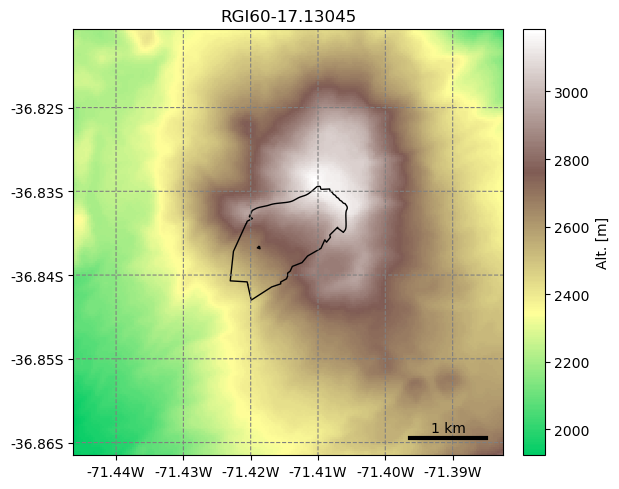

In [31]:
from oggm import graphics
graphics.plot_domain(nevado_gdir, figsize=(6, 5))

Another advantage of glacier directories is their persistence on disk: once created, they can be recovered from the same location by using init_glacier_directories again, but without keyword arguments:

In [32]:
# Fetch the LOCAL pre-processed directories - note that no arguments are used!
#gdirs = workflow.init_glacier_directories(rgi_ids)
nevado_gdirs = workflow.init_glacier_directories(glaciar_nevado)

2024-04-05 18:10:11: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


## Accessing data in the preprocessed directories
Glacier directories are the central object for model users and developpers to access data for this glacier. Let’s say for example that you would like to retrieve the climate data that we have prepared for you. You can ask the glacier directory to tell you where this data is:

In [33]:
#gdir.get_filepath('climate_historical')
#now for nevado: 
nevado_gdir.get_filepath('climate_historical')

'/tmp/OGGM/OGGM-GettingStarted-10m/per_glacier/RGI60-17/RGI60-17.13/RGI60-17.13045/climate_historical.nc'

/opt/conda/envs/oggm_env/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(
/opt/conda/envs/oggm_env/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(


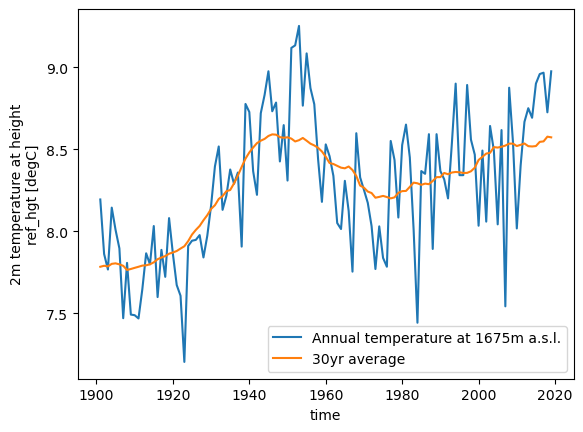

In [34]:
# One can then use familiar tools to read and process the data further:
import xarray as xr
import matplotlib.pyplot as plt
# Open the file for Nevados de Chillán using xarray
with xr.open_dataset(nevado_gdir.get_filepath('climate_historical')) as ds:
    ds = ds.load()
# Plot the data
ds.temp.resample(time='AS').mean().plot(label=f'Annual temperature at {int(ds.ref_hgt)}m a.s.l.');
ds.temp.resample(time='AS').mean().rolling(time=31, center=True, min_periods=15).mean().plot(label='30yr average');
plt.legend();
# got FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead

In [35]:
# As a result of the processing workflow the glacier directories can store many more files. 
# If you are interested, you can have a look at the list:
import os
print(os.listdir(nevado_gdir.dir))

['model_flowlines.pkl', 'glacier_grid.json', 'fl_diagnostics_spinup_historical.nc', 'dem.tif', 'model_diagnostics_spinup_historical.nc', 'log.txt', 'climate_historical.nc', 'outlines.tar.gz', 'model_geometry_spinup_historical.nc', 'elevation_band_flowline.csv', 'diagnostics.json', 'inversion_input.pkl', 'model_geometry_historical.nc', 'downstream_line.pkl', 'intersects.tar.gz', 'gridded_data.nc', 'model_diagnostics_historical.nc', 'inversion_output.pkl', 'dem_source.txt', 'mb_calib.json', 'model_flowlines_dyn_melt_f_calib.pkl', 'inversion_flowlines.pkl', 'fl_diagnostics_historical.nc']


## OGGM tasks
There are two different types of “tasks” in OGGM:

Entity Tasks : Standalone operations to be realized on one single glacier entity, independently from the others. The majority of OGGM tasks are entity tasks. They are parallelisable: the same task can run on several glaciers in parallel.

Global Tasks : Tasks which require to work on several glacier entities at the same time. Model parameter calibration or the compilation of several glaciers’ output are examples of global tasks.

OGGM implements a simple mechanism to run a specific task on a list of GlacierDirectory objects. Here, for the sake of the demonstration of how tasks work, we are going to compute something new from the directory:

In [36]:
from oggm import tasks

# run the compute_inversion_velocities task 
workflow.execute_entity_task(tasks.compute_inversion_velocities, nevado_gdirs);

2024-04-05 18:10:13: oggm.workflow: Execute entity tasks [compute_inversion_velocities] on 1 glaciers


Compute inversion velocities is an optional task in the OGGM workflow. It computes the ice velocity along the flowline resulting from the ice flux from a glacier in equilibrium (more on this in the documentation or the dedicated tutorial).

Note that OGGM tasks often do not return anything (the statement above seems to be “void”, i.e. doing nothing). The vast majority of OGGM tasks actually write data to disk in order to retrieve it later. Let’s have a look at the data we just added to the directory:

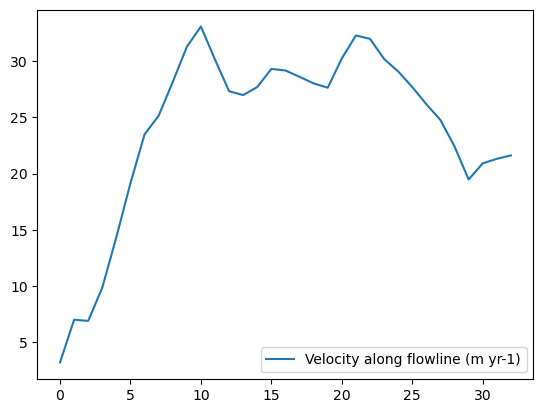

In [37]:
# Computing inversion velocities
nevado_inversion_output = nevado_gdir.read_pickle('inversion_output')  # The task above wrote the data to a pickle file - but we write to plenty of other files!

# Take the first flowline
fl_nev = nevado_inversion_output[0]
# the last grid points often have irrealistic velocities
# because of the equilibrium assumption
nevado_vel = fl_nev['u_surface'][:-1]  
plt.plot(nevado_vel, label='Velocity along flowline (m yr-1)'); plt.legend();

## Computing “elevation band” and “centerline” flowlines
https://oggm.org/tutorials/stable/notebooks/10minutes/elevation_bands_vs_centerlines.html

In [38]:
from oggm import cfg, utils, workflow, graphics, tasks
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
cfg.initialize(logging_level='WARNING')

2024-04-05 18:12:00: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-05 18:12:00: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-05 18:12:00: oggm.cfg: Multiprocessing: using all available processors (N=2)


In [40]:
# Pick the glacier you want! Here I use Glaciar Nevado 
glaciar_nevado = ['RGI60-17.13045']

# Where to store the data 
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-centerlines', reset=True)

# We start from prepro level 3 with all data ready - note the url here
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
nevado_gdirs = workflow.init_glacier_directories(glaciar_nevado, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
nev_gdir_cl = nevado_gdirs[0]
nev_gdir_cl

2024-04-05 18:12:02: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-04-05 18:12:02: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


<oggm.GlacierDirectory>
  RGI id: RGI60-17.13045
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 1.256 km2
  Lon, Lat: (-71.4149, -36.8356)
  Grid (nx, ny): (219, 217)
  Grid (dx, dy): (26.0, -26.0)

In [41]:
# Elevation band flowline
# New working directory
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-elevbands', reset=True)

# Note the new url
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/'
nevado_gdirs = workflow.init_glacier_directories(glaciar_nevado, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
nev_gdir_eb = nevado_gdirs[0]
nev_gdir_eb

2024-04-05 18:12:35: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-04-05 18:12:35: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


<oggm.GlacierDirectory>
  RGI id: RGI60-17.13045
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 1.256 km2
  Lon, Lat: (-71.4149, -36.8356)
  Grid (nx, ny): (219, 217)
  Grid (dx, dy): (26.0, -26.0)